# Lesson 41: Solution to Exercise 5

*This exercise was generated from a Jupyter notebook.  You can download the notebook [here](l41_exercise_5.ipynb).*

In [1]:
# Standard library stuff
import glob

# Our workhorses
import numpy as np
import pandas as pd

# Module with curve fitting
import scipy.optimize

# Our image processing tools
import skimage.filters
import skimage.io
import skimage.morphology

# This is how we import the module of Matplotlib we'll be using
import matplotlib.pyplot as plt

# Seaborn makes plots pretty!
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Set JB's favorite Seaborn settings
rc={'lines.linewidth': 2, 'axes.labelsize': 18, 'axes.titlesize': 18, 
    'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)

## Problem 5.1: Growth curves from a movie
At the dawn of the molecular revolution in biology, key experiments by Jacques Monod in which he measured growth curves of bacteria under different conditions exposed some of the mechanisms of regulation of gene expression.  Those growth curves were measured in a bulk solution..  In this exercise, we will measure bacterial growth starting from a *two bacteria*.  The movie shows *Bacillus subtilis* constitutively expressing mCherry growing under slow growth conditions.  These data were kindly donated by Jin Park from the Elowitz lab here at Caltech.

**a)** Load in the series of images contained in the directory created when you unzipped [`bacterial_growth.zip`](http://bois.caltech.edu/bootcamp/bacterial_growth.zip).  Be sure that however you store them (a list or tuple or other object) has the frames in the proper order.

**b)** Segment the images to separate bacteria from background.  You do not need to segment individual bacteria; this would likely require some more advanced techniques involving edge detection that we haven't covered in bootcamp.

**c)** Show a representative image from the stack (with the segmentation overlayed in green) of images with a 10 µm scale bar burned in.

**d)** Plot a growth curve for this growing colony.  What values should be on the $y$-axis?  (This is one of those times where I ask an open question for which there is no "right" answer.)

**e)** Perform a regression on this growth curve to estimate the time constant for the exponential growth.  Be sure to check out the `README` file in the directory containing the images to get the appropriate metadata.

### Problem 5.1: solution
**a)** We will load the images into a tuple, where the index of the tuple corresponds to the frame number.  Under normal circumstances, we would do data validation to make sure there are no skipped frames, but in the interest of brevity, we will proceed assuming all data are properly labeled and organized.

In [2]:
# Initialize list of images
ims = []

# Read each image into memory
for fname in glob.glob('../data/bacterial_growth/bacillus_*.tif'):
    ims.append(skimage.io.imread(fname))
    
# Store it as a tuple so we don't mess with it
ims = tuple(ims)

# How many?
print('There are', len(ims), 'images.')

There are 55 images.


Let's take a quick look at a few of the images.  We'll look at frames `0`, `15`, `30`, and `45`.

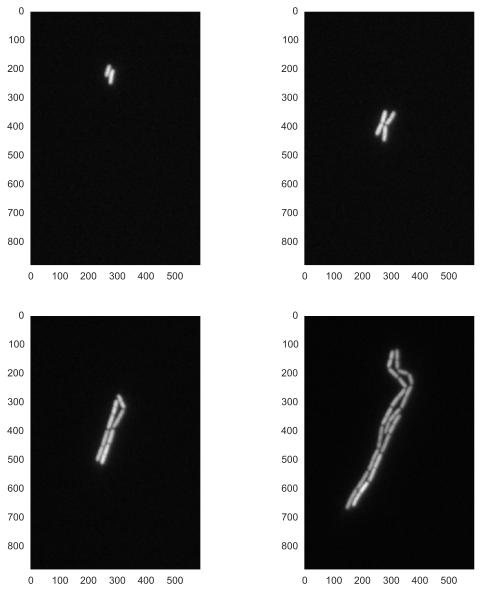

In [3]:
# Display phase and thresholded image
with sns.axes_style('dark'):
    fig, ax = plt.subplots(2, 2, figsize=(9, 10))
    ax[0,0].imshow(ims[0], cmap=plt.cm.gray)
    ax[0,1].imshow(ims[15], cmap=plt.cm.gray)
    ax[1,0].imshow(ims[30], cmap=plt.cm.gray)
    ax[1,1].imshow(ims[45], cmap=plt.cm.gray)

**b)** We will take a similar approach as in [Lesson 34](l34_intro_to_image_processing.html) to segement the image.  We will simply threshold the image using Otsu's method.

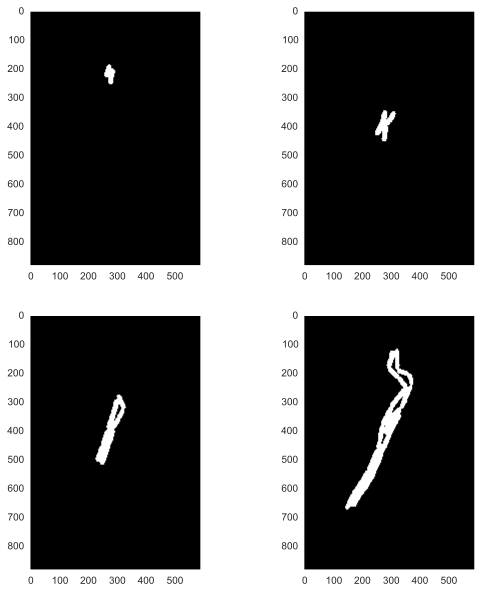

In [6]:
# Initialize list of thresholded images
ims_bw = [None] * len(ims)

# Threshold the images
for i, im in enumerate(ims):
    thresh = skimage.filters.threshold_otsu(im)
    ims_bw[i] = im > thresh
    
# Take a look at the result
with sns.axes_style('dark'):
    fig, ax = plt.subplots(2, 2, figsize=(9, 10))
    ax[0,0].imshow(ims_bw[0], cmap=plt.cm.gray)
    ax[0,1].imshow(ims_bw[15], cmap=plt.cm.gray)
    ax[1,0].imshow(ims_bw[30], cmap=plt.cm.gray)
    ax[1,1].imshow(ims_bw[45], cmap=plt.cm.gray)

This is pretty good.  Certainly good enough for generating a growth curve.

**c)** We will overlay the segmentation on image 40.  We'll use the green channel.  To burn in the scale bar, we remember that images are stored as NumPy arrays.  In looking at the README file associated with the images, the interpixel distance is 64.5 nm.  So, we need the scale bar to be $10 / 0.0645 = 155$ pixels long.  We will burn it in the lower right corner.

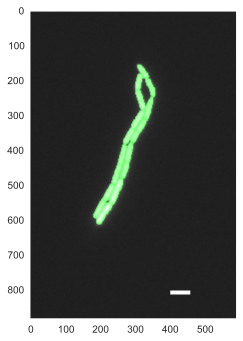

In [7]:
# Image to use, and normalize
im = np.copy(ims[40]).astype(float)
im /= im.max()

# Burn scale bar
im[800:810, 400:455] = 1.0

# Build RGB image by stacking grayscale images
im_rgb = np.dstack(3 * [im / im.max()])

# Saturate red channel wherever there are white pixels in thresh image
im_rgb[ims_bw[40], 1] = 1.0

# Show the result
with sns.axes_style('dark'):
    plt.imshow(im_rgb)

The segmentation overshoots the bacteria.  We might want to try to refine this a bit.  We could do **adaptive thresholding**.  We perform automatic thresholding on subimages throughout the image.  We will take subimages to be 51 $\times$ 51, since that would span the width of one bacteriu, and then some, thereby avoiding the issue of thresholding within a single bacterium (and adaptive thresholding needs an off image block size).  Adaptive thresholding itself returns an array of Booleans.  Let's give it a shot.

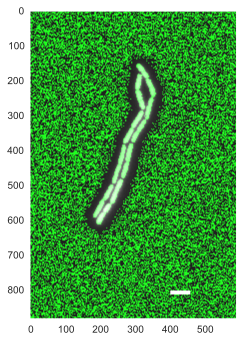

In [8]:
# Initialize list of thresholded images
ims_bw = [None] * len(ims)

# Threshold the images
for i, im in enumerate(ims):
    ims_bw[i] = skimage.filters.threshold_adaptive(im, 51)

# Image to use, and normalize
im = np.copy(ims[40]).astype(float)
im /= im.max()

# Burn scale bar
im[800:810, 400:455] = 1.0

# Build RGB image by stacking grayscale images
im_rgb = np.dstack(3 * [im / im.max()])

# Saturate red channel wherever there are white pixels in thresh image
im_rgb[ims_bw[40], 1] = 1.0

# Show the result
with sns.axes_style('dark'):
    plt.imshow(im_rgb)

Whoa!  It did a great job with the bacteria, but the background got really messed up.  We could include pixels that are unity in both the adaptive and Otsu thresholding to take care of this.  We then use `np.logical_and()` to do an element-by-element `AND` operation on the arrays.

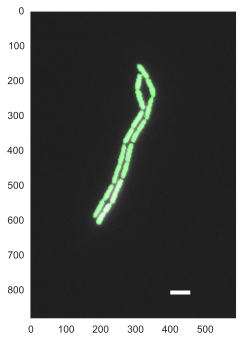

In [9]:
# Initialize list of thresholded images
ims_bw = [None] * len(ims)

# Threshold the images
for i, im in enumerate(ims):
    thresh_otsu = skimage.filters.threshold_otsu(im)
    im_bw = im > thresh_otsu
    ims_bw[i] = np.logical_and(skimage.filters.threshold_adaptive(im, 51), im_bw)

# Image to use, and normalize
im = np.copy(ims[40]).astype(float)
im /= im.max()

# Burn scale bar
im[800:810, 400:455] = 1.0

# Build RGB image by stacking grayscale images
im_rgb = np.dstack(3 * [im / im.max()])

# Saturate red channel wherever there are white pixels in thresh image
im_rgb[ims_bw[40], 1] = 1.0

# Show the result
with sns.axes_style('dark'):
    plt.imshow(im_rgb)

Very nice!

**d)** To plot the growth curve, we can plot the total bacterial area on the $y$-axis, versus time on the $x$-axis.  To get the total area, we need to compute the total number of "bacterial" pixels in a given image, multiplied by the pixel area, which is $(64.5\text{ nm})^2 = 4160.25\text{ nm}^2$.  Also, according to the metadata, we have one frame every 15 minutes.

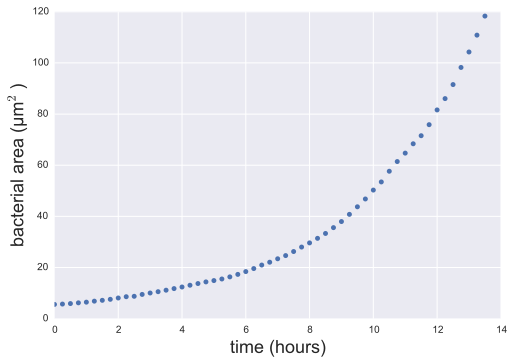

In [10]:
# Compute pixel area
pixel_area = 0.0645**2

# Get total bacterial area
bac_area = np.empty(len(ims_bw))
for i, im_bw in enumerate(ims_bw):
    bac_area[i] = im_bw.sum() * pixel_area
   
# Get time in units of hours
t = 0.25 * np.arange(len(ims_bw))

# Plot the result
plt.plot(t, bac_area, marker='.', linestyle='', markersize=10)
plt.xlabel('time (hours)')
plt.ylabel('bacterial area (µm$^2$)')

**e)** To perform the regression on the growth curve, we assume exponential growth, or

\begin{align}
b(t) = b_0 \mathrm{e}^{t/\tau},
\end{align}

where $\tau$ is the characteristic time for growth.  We *could* just take the logarithm of the data and do a linear regression, but we will perform a nonlinear regression here.


b_0 = 4.34 sq. µm
  τ = 4.09 hours



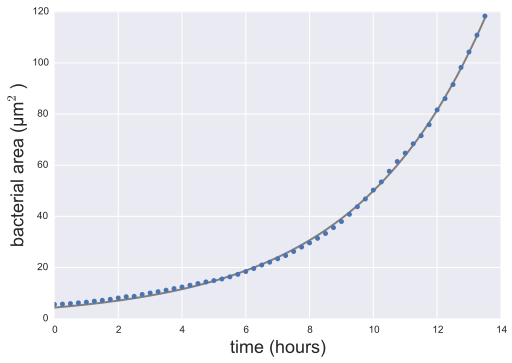

In [11]:
# Define the fit function
def exp_growth(t, log_b_0, log_tau):
    """Exponential growth with log arguments."""
    return np.exp(log_b_0) * np.exp(t / np.exp(log_tau))

# Initial guess
p0 = np.log(np.array([5.0, 12.0]))

# Perform the curve fit
log_p, _ = scipy.optimize.curve_fit(exp_growth, t, bac_area, p0)

# Pull out and print parameters
print("""
b_0 = {0:.2f} sq. µm
  τ = {1:.2f} hours
""".format(*tuple(np.exp(log_p))))

# Generate smooth curve
t_smooth = np.linspace(0, t.max(), 200)
y_smooth = exp_growth(t_smooth, *tuple(log_p))

# Make smooth plot and plot data
plt.plot(t_smooth, y_smooth, marker='None', linestyle='-', color='gray')
plt.plot(t, bac_area, marker='.', linestyle='', markersize=10)
plt.xlabel('time (hours)')
plt.ylabel('bacterial area (µm$^2$)')

There is some systematic error, it appears, with the data being consistently above the curve at short times and then below for intermediate times.  This could be due to thresholding, or due to small changes in conditions over time.

<br />

## Problem 5.2: Beak depth and lengths

In [Exercise 4](e04.html), you munged and plotted some data on beak widths and depths of Darwin's finches.  In this problem, we will work to quantify these data.  We will perform a simple analysis in which we perform a linear regression to get the dependence of beak depth on beak length.

**a)** Perform a linear regression on each of the ten (year-species) pairs.  Show your regression line on plots like you make in Exercise 4.

**b)** Comment on the observed slopes and how they change over time.

**c)** Perform any other analysis on the data that you see fit or are curious about.

### Problem 5.2: solution
In [Exercise 4](e04.html), we made a `DataFrame` with all of the data from the Grant data set.  I saved this as `../data/grant_finch_data.csv`.

**a)** We first write a function to do a linear regression.  We could use `scipy.ooptimize.curve_fit` to do this, but there is a much easier (and faster) way.  If we are fitting data with a polynomial function (like a linear, quadratic, cubic, etc.), we can use `np.polyfit()` to perform the fit.  This takes as arguments the $x$ data, the $y$ data, and then a number representing the degree of the polynomial.  So, to fit a linear regression, we would use `np.polyfit(x, y, 1)`.  The function returns a NumPy array, where the first value is the slope and the second the intercept.

Before we do that, though, we have to munge the data.  We want to get all of the unique year-species pairs.  We can use the `unique()` method of a Pandas `Series` (a column in a `DataFrame`) to get the years and series.

In [12]:
# Load the data
df = pd.read_csv('../data/grant_finch_data.csv', comment='#')

# Get unique years
years = df['year'].unique()
specieses = df['species'].unique()

# Show what they are
print('    years =', years)
print('specieses =', specieses)

    years = [1973 1975 1987 1991 2012]
specieses = ['fortis' 'scandens']


Now, we will loop through each year-species pair, and compute the slope and intercept.  It is most convenient to store these in a `DataFrame` when we are done.

In [13]:
# Initialize list-of-lists storing results of regressions
data_list = []

# Loop through and do regressions
for year in years:
    for species in specieses:
        # Get which parts of the df we want to pull out
        inds = (df['year'] == year) & (df['species'] == species)
        slope, intercept = np.polyfit(df['beak length (mm)'][inds], 
                                      df['beak depth (mm)'][inds], 1)
        data_list.append([year, species, slope, intercept])
        
# Build DataFrame
df_reg = pd.DataFrame(columns=['year', 'species', 'slope', 'intercept'],
                      data=data_list)

# Check out the results
df_reg

,year,species,slope,intercept
0,1973,fortis,1.040472,-1.512074
1,1973,scandens,0.398956,3.650209
2,1975,fortis,0.893896,-0.274472
3,1975,scandens,0.465205,2.390875
4,1987,fortis,0.717582,1.474941
5,1987,scandens,0.262259,5.416853
6,1991,fortis,0.787481,0.686189
7,1991,scandens,0.262235,5.421256
8,2012,fortis,0.656104,1.704892
9,2012,scandens,0.464642,2.949119


The slope is what is really interesting here.  It describes how the beak shapes scales as it gets bigger.  I.e., does a bird with a longer beak have a proportionally deeper beak?  We can plot the slope for each species.  For sparse data like these, it is often useful to connect the points with lines.

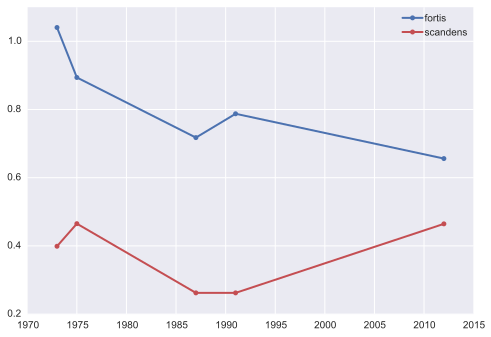

In [14]:
# Pull out data by species
df_fortis = df_reg[df_reg['species'] == 'fortis']
df_scandens = df_reg[df_reg['species'] == 'scandens']

# Plot the slopes over time
plt.plot(df_fortis['year'], df_fortis['slope'], marker='.', markersize=10, 
         linestyle='-', color=sns.color_palette()[0])
plt.plot(df_scandens['year'], df_scandens['slope'], marker='.', markersize=10, 
         linestyle='-', color=sns.color_palette()[2])
plt.legend(('fortis', 'scandens'), loc='upper right')

We see that the beak goemetry of *Geospiza fortis* has been slowly drifting to be more like *scandens*.

To plot all of our curve fits together, we adjust our `plot_beak_data()` method from [Exercise 4](../exercises/e04.html).

In [15]:
def plot_beak_data(ax, df, df_reg, year, legend=False):
    """
    Plot beak length and beak depth data for a given year
    on a given axis.
    """

    # Extract data we want
    df_fortis = df[(df['year']==year) & (df['species']=='fortis')]
    df_scandens = df[(df['year']==year) & (df['species']=='scandens')]
    
    # Pull out slope and intercept
    slope_fortis = df_reg[(df_reg['year']==year) \
                        & (df_reg['species']=='fortis')]['slope'].iloc[0]
    slope_scandens = df_reg[(df_reg['year']==year) \
                        & (df_reg['species']=='scandens')]['slope'].iloc[0]
    intercept_fortis = df_reg[(df_reg['year']==year) \
                        & (df_reg['species']=='fortis')]['intercept'].iloc[0]
    intercept_scandens = df_reg[(df_reg['year']==year) \
                        & (df_reg['species']=='scandens')]['intercept'].iloc[0]


    # Generate the lines
    x_line = np.array([9, 16])
    y_line_fortis = slope_fortis * x_line + intercept_fortis
    y_line_scandens = slope_scandens * x_line + intercept_scandens

    # Plot the result
    ax.plot(df_fortis['beak length (mm)'], df_fortis['beak depth (mm)'],
            marker='.', linestyle='None', color=sns.color_palette()[0], 
            alpha=0.5)
    ax.plot(df_scandens['beak length (mm)'], df_scandens['beak depth (mm)'],
            marker='.', linestyle='None', color=sns.color_palette()[2], 
            alpha=0.5)
    ax.plot(x_line, y_line_fortis, marker='None', linestyle='-', 
            color='gray')
    ax.plot(x_line, y_line_scandens, marker='None', linestyle='-', 
            color='gray')

    # Clean up
    ax.margins(0.02)
    ax.set_xlabel('beak length (mm)', fontsize=12)
    ax.set_ylabel('beak depth (mm)', fontsize=12)
    ax.set_title(str(year), fontsize=14)
    if legend:
        ax.legend(('fortis', 'scandens'), loc='upper left')
    
    return ax

With this in hand, we can generate the plots.

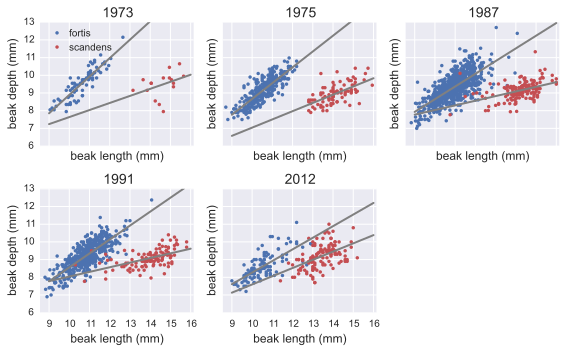

In [16]:
# Plots playout
fig, ax = plt.subplots(2, 3, figsize=(8, 5), sharex=True, sharey=True)

# Which axes to use
ax_inds = ((0,0), (0, 1), (0,2), (1,0), (1, 1))

# Loop through years and make plots
for i, year in enumerate(years):
    if i == 0:
        legend = True
    else:
        legend=False
        
    _ = plot_beak_data(ax[ax_inds[i]], df, df_reg, year, legend=legend)
    
# Tidy up
ax[1, 2].axis('off')
ax[0, 0].set_ylim((6, 13))
fig.tight_layout()

**b)** The slope for *scandens* gets smaller as time goes by, and the lengths also decreases.  This suggests that the beaks are getting shorter while not getting deeper, drifting toward the geometry of *fortis*.

**c)** This is wide open, and I look forward to seeing what you all do!